#use spark to load and visualize data

In [2]:
!pip install pyspark

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import pyspark.sql.types as typ
import pyspark.sql.functions as fn
from pyspark import SparkContext
from pyspark.sql import SparkSession
from pyspark.sql.types import FloatType, TimestampType
spark = SparkSession.builder.appName('SparkByExamples.com').getOrCreate()
sc = spark.sparkContext

In [5]:
path = '/content/drive/MyDrive/228_project/apple_dataset/AAPL.csv'
df = spark.read.option("header", True).csv(path)
df.show(2)
df.printSchema()

+----------+--------+--------+--------+--------+---------+---------+
|      Date|    Open|    High|     Low|   Close|Adj Close|   Volume|
+----------+--------+--------+--------+--------+---------+---------+
|1980-12-12|0.128348|0.128906|0.128348|0.128348| 0.100600|469033600|
|1980-12-15|0.122210|0.122210|0.121652|0.121652| 0.095352|175884800|
+----------+--------+--------+--------+--------+---------+---------+
only showing top 2 rows

root
 |-- Date: string (nullable = true)
 |-- Open: string (nullable = true)
 |-- High: string (nullable = true)
 |-- Low: string (nullable = true)
 |-- Close: string (nullable = true)
 |-- Adj Close: string (nullable = true)
 |-- Volume: string (nullable = true)



#data preprocess

In [6]:
# only select date and close price
df = df.select('Date', 'Close')
df.show(2)

+----------+--------+
|      Date|   Close|
+----------+--------+
|1980-12-12|0.128348|
|1980-12-15|0.121652|
+----------+--------+
only showing top 2 rows



In [7]:
# change the data type
df = df.withColumn("Close",df.Close.cast(FloatType()))
df = df.withColumn("Date", df.Date.cast(TimestampType()))
df.printSchema()

root
 |-- Date: timestamp (nullable = true)
 |-- Close: float (nullable = true)



In [8]:
#only choose data after year 2020
df = df.where(df.Date >= '2020-01-01')
print('number of samples: ', df.count())
df.show(2)

number of samples:  425
+-------------------+-------+
|               Date|  Close|
+-------------------+-------+
|2020-01-02 00:00:00|75.0875|
|2020-01-03 00:00:00|74.3575|
+-------------------+-------+
only showing top 2 rows



In [9]:
df.describe('Close').show()

+-------+------------------+
|summary|             Close|
+-------+------------------+
|  count|               425|
|   mean|111.04844692454618|
| stddev|26.162910469862393|
|    min|           56.0925|
|    max|            156.69|
+-------+------------------+



In [10]:
# Checking duplicates and filling missing observations with means.
print('Count of rows: {}'.format(df.count())) 
print('Count of distinct rows: {}'.format(df.distinct().count()))

Count of rows: 425
Count of distinct rows: 425


#Visualization

In [11]:
%matplotlib inline 
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
sns.set_style('whitegrid')
plt.style.use("fivethirtyeight")

In [12]:
df_pd = df.toPandas()

In [13]:
# Sort DataFrame by date
df_pd = df_pd.sort_values('Date')

In [14]:
df_pd.head()

,Date,Close
0,2020-01-02,75.087502
1,2020-01-03,74.357498
2,2020-01-06,74.949997
3,2020-01-07,74.597504
4,2020-01-08,75.797501


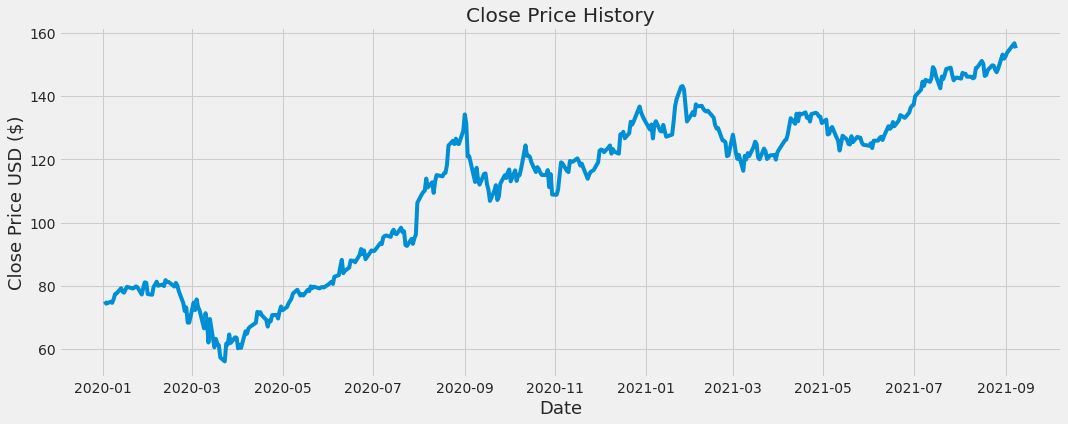

In [15]:
plt.figure(figsize=(16,6))
plt.title('Close Price History')
plt.plot(df_pd['Date'], df_pd['Close'])
# plt.xticks(range(0,df_pd.shape[0],500),df_pd['Date'].loc[::500],rotation=45)
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.show()

# train, test dataset split

In [16]:
# since it`s time series data, sorted by date, need to manually split the dataset
data = df_pd.filter(['Close'])
dataset = data.values
# Get the number of rows to train the model on
training_data_len = int(np.ceil( len(dataset) * .8 ))

training_data_len

340

In [ ]:
# Scale the data
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)

print(scaled_data)

In [18]:
train_data = scaled_data[0:int(training_data_len), :]
train_data.shape

(340, 1)

In [19]:
# Create the training data set 
# Create the scaled training data set
train_data = scaled_data[0:int(training_data_len), :]
# Split the data into x_train and y_train data sets
x_train = []
y_train = []
timestamps = 15
for i in range(timestamps, len(train_data)):
    x_train.append(train_data[i-timestamps:i, 0])
    y_train.append(train_data[i, 0])
    # if i<= 101:
    #     print(x_train)
    #     print(y_train)
    #     print()
        
# Convert the x_train and y_train to numpy arrays 
x_train, y_train = np.array(x_train), np.array(y_train)

# Reshape the data
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

print("x_train shpe:", x_train.shape)
print("y_train shape:", y_train.shape)

x_train shpe: (325, 15, 1)
y_train shape: (325,)


#LSTM model

In [20]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow import  keras

In [21]:
model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape= (x_train.shape[1], 1)))
model.add(LSTM(64, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 15, 128)           66560     
                                                                 
 lstm_1 (LSTM)               (None, 64)                49408     
                                                                 
 dense (Dense)               (None, 25)                1625      
                                                                 
 dense_1 (Dense)             (None, 1)                 26        
                                                                 
Total params: 117,619
Trainable params: 117,619
Non-trainable params: 0
_________________________________________________________________


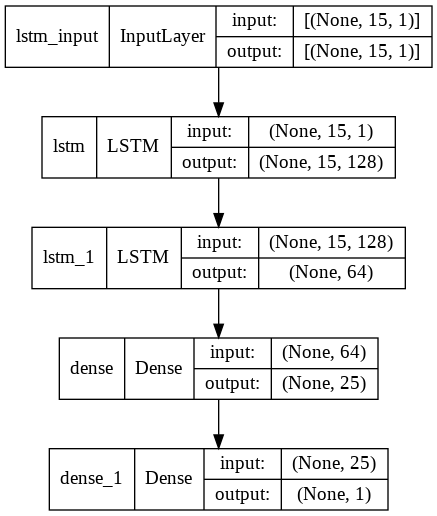

In [22]:
keras.utils.plot_model(model, show_shapes=True)

#Training model

In [23]:
# Compile the model
model.compile(optimizer='adam', loss=keras.losses.MeanSquaredError(),
              metrics=[keras.metrics.RootMeanSquaredError(name='rmse')])

In [24]:
# Fitting the RNN to the Training set
history = model.fit(x_train, y_train, epochs = 100, batch_size = 32)

Epoch 1/100
11/11 [==============================] - 7s 12ms/step - loss: 0.0644 - rmse: 0.2537
Epoch 2/100
11/11 [==============================] - 0s 12ms/step - loss: 0.0135 - rmse: 0.1163
Epoch 3/100
11/11 [==============================] - 0s 13ms/step - loss: 0.0072 - rmse: 0.0847
Epoch 4/100
11/11 [==============================] - 0s 13ms/step - loss: 0.0041 - rmse: 0.0637
Epoch 5/100
11/11 [==============================] - 0s 12ms/step - loss: 0.0035 - rmse: 0.0588
Epoch 6/100
11/11 [==============================] - 0s 13ms/step - loss: 0.0027 - rmse: 0.0516
Epoch 7/100
11/11 [==============================] - 0s 14ms/step - loss: 0.0026 - rmse: 0.0506
Epoch 8/100
11/11 [==============================] - 0s 12ms/step - loss: 0.0027 - rmse: 0.0518
Epoch 9/100
11/11 [==============================] - 0s 14ms/step - loss: 0.0025 - rmse: 0.0503
Epoch 10/100
11/11 [==============================] - 0s 12ms/step - loss: 0.0024 - rmse: 0.0495
Epoch 11/100
11/11 [===================

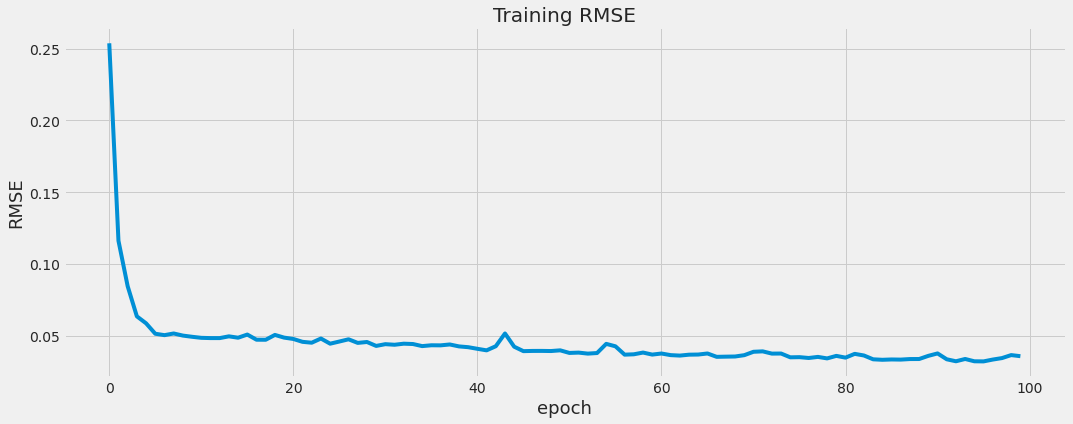

In [25]:
plt.figure(figsize=(16,6))
plt.title('Training RMSE')
plt.plot(history.history["rmse"])
plt.xlabel('epoch', fontsize=18)
plt.ylabel('RMSE', fontsize=18)
plt.show()

#set up test dataset

In [26]:
test_data = scaled_data[training_data_len - timestamps: , :]
# Create the data sets x_test and y_test
x_test = []
y_test = dataset[training_data_len:, :]
for i in range(timestamps, len(test_data)):
    x_test.append(test_data[i-timestamps:i, 0])
    
# Convert the data to a numpy array
x_test = np.array(x_test)

# Reshape the data
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1 ))

In [27]:
x_test.shape

(85, 15, 1)

#predicting

In [28]:
# Get the models predicted price values 
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

In [29]:
print(predictions)

[[126.33077 ]
 [125.72031 ]
 [124.804115]
 [123.135666]
 [122.401306]
 [122.91001 ]
 [123.37054 ]
 [123.30664 ]
 [123.05272 ]
 [123.570564]
 [123.627106]
 [124.01087 ]
 [124.33327 ]
 [124.51009 ]
 [124.09726 ]
 [123.40458 ]
 [122.73138 ]
 [122.491066]
 [122.042595]
 [122.359955]
 [122.836235]
 [123.50756 ]
 [124.169334]
 [124.321945]
 [124.60321 ]
 [125.763405]
 [126.58131 ]
 [127.19565 ]
 [128.01997 ]
 [128.23155 ]
 [128.7195  ]
 [129.62276 ]
 [130.27528 ]
 [130.55588 ]
 [130.49875 ]
 [130.84311 ]
 [131.66061 ]
 [132.56644 ]
 [133.31796 ]
 [134.60071 ]
 [136.25021 ]
 [138.28613 ]
 [139.32161 ]
 [140.25023 ]
 [140.57213 ]
 [140.89684 ]
 [142.18486 ]
 [143.09259 ]
 [142.89233 ]
 [141.11559 ]
 [140.60207 ]
 [140.36256 ]
 [140.78673 ]
 [141.88045 ]
 [142.97945 ]
 [143.00488 ]
 [142.09465 ]
 [141.39238 ]
 [141.01656 ]
 [140.77159 ]
 [141.25818 ]
 [141.67525 ]
 [142.00237 ]
 [141.90436 ]
 [141.70467 ]
 [141.34096 ]
 [141.13763 ]
 [142.02043 ]
 [143.00827 ]
 [144.37769 ]
 [145.09616 ]
 [144.

In [30]:
# Get the root mean squared error (RMSE)
rmse = np.sqrt(np.mean(((predictions - y_test) ** 2)))
rmse

4.9339175

In [31]:
# Plot the data
train = data[:training_data_len]
test = data[training_data_len:]
test['Predictions'] = predictions
test['Errors'] = test['Close'] - test['Predictions']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [32]:
print(test)
# print(type(test))
# print(test.values)

          Close  Predictions    Errors
340  126.849998   126.330772  0.519226
341  125.910004   125.720306  0.189697
342  122.769997   124.804115 -2.034119
343  124.970001   123.135666  1.834335
344  127.449997   122.401306  5.048691
..          ...          ...       ...
420  152.509995   145.857193  6.652802
421  153.649994   146.687149  6.962845
422  154.300003   147.483856  6.816147
423  156.690002   148.171875  8.518127
424  155.110001   149.330643  5.779358

[85 rows x 3 columns]


#Visulize the result

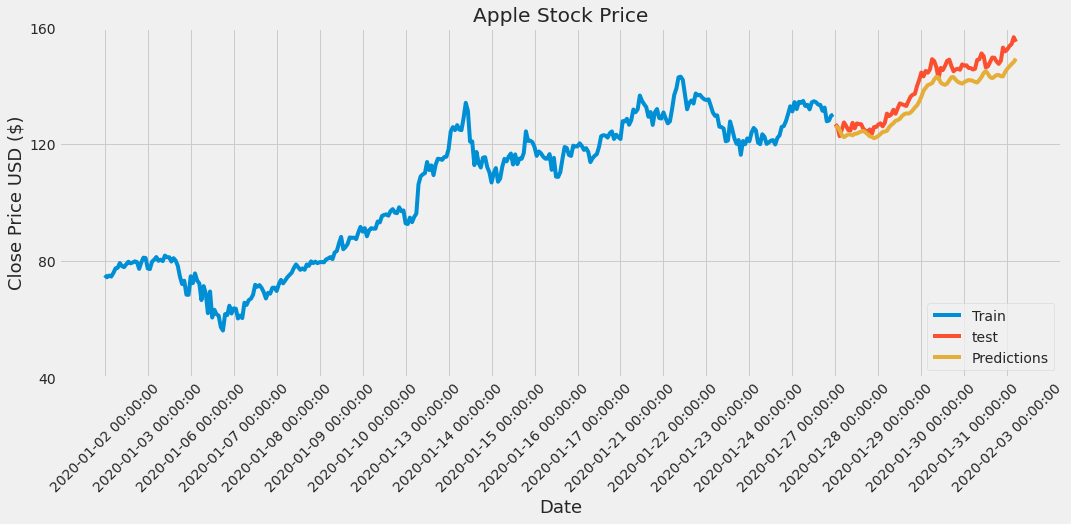

In [33]:
# Visualize the data
plt.figure(figsize=(16,6))
plt.title('Apple Stock Price')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.xticks(range(0,df_pd.shape[0],20),df_pd['Date'].loc[::],rotation=45)
plt.yticks(np.arange(0, 200, step=40))
plt.ylim(ymin=40)
plt.plot( train['Close'])
plt.plot(test[['Close', 'Predictions']])
plt.legend(['Train', 'test', 'Predictions'], loc='lower right')
plt.show()

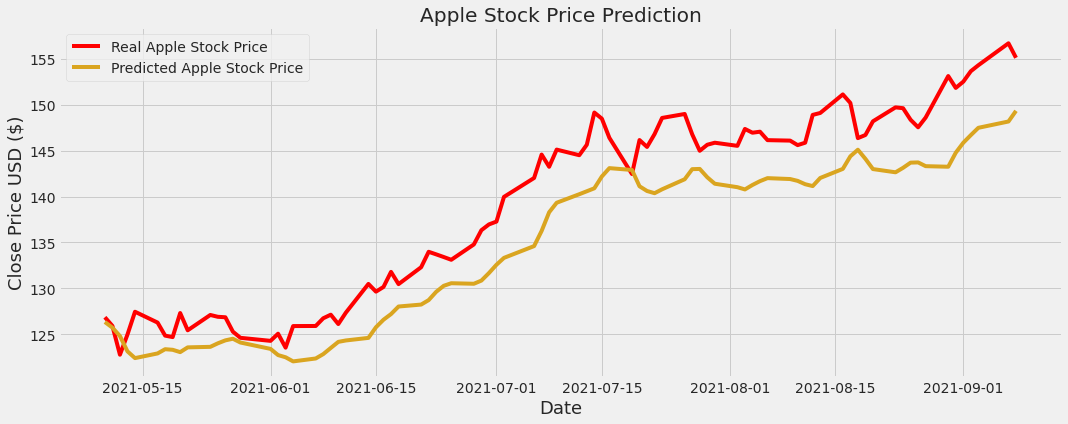

In [34]:
# Visualising only the test data
plt.figure(figsize=(16,6))
plt.plot(df_pd.loc[training_data_len:, 'Date'],test["Close"], color = 'red', label = 'Real Apple Stock Price')
plt.plot(df_pd.loc[training_data_len:, 'Date'],predictions, color = 'goldenrod', label = 'Predicted Apple Stock Price')
plt.title('Apple Stock Price Prediction')
plt.xlabel('Date',fontsize=18)
plt.ylabel('Close Price USD ($)',fontsize=18)
plt.legend()
plt.show()

In [35]:
result = df_pd[training_data_len:]
result['Predictions'] = predictions
result["Error"] = result["Close"] - result["Predictions"]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [36]:
result.head()

,Date,Close,Predictions,Error
340,2021-05-10,126.849998,126.330772,0.519226
341,2021-05-11,125.910004,125.720306,0.189697
342,2021-05-12,122.769997,124.804115,-2.034119
343,2021-05-13,124.970001,123.135666,1.834335
344,2021-05-14,127.449997,122.401306,5.048691


#demo

In [37]:
# create demo dataset
demo_data =  {'close':[20, 21, 19, 18,19,20,21,22,23,25,29,20,17,15,19,20]}
demo_df = pd.DataFrame(demo_data)
demo_df_test = demo_df.values
time_steps_demo = 15
demo_x_test = []
demo_y_test = demo_df_test[:, :]
demo_scaled = scaler.fit_transform(demo_df_test)
demo_scaled_test = demo_scaled[: , :]
# prepare the sequence data
for i in range(time_steps_demo, len(demo_scaled_test)):
    demo_x_test.append(demo_scaled_test[i-time_steps_demo:i, 0])
    
# Convert the data to a numpy array
demo_x_test = np.array(demo_x_test)

# Reshape the data
demo_x_test = np.reshape(demo_x_test, (demo_x_test.shape[0], demo_x_test.shape[1], 1 ))
# predict and inverse scalse
demo_pred = model.predict(demo_x_test)
demo_pred = scaler.inverse_transform(demo_pred)

In [38]:
print(demo_pred)
# Calculate the rmse
rmse = np.sqrt(np.mean(((demo_pred - demo_y_test) ** 2)))
print(rmse)

[[18.403856]]
3.7774089672048285


#demo 2, predict future day stock price

In [ ]:
print(test_data.shape)
print(test_data)

In [41]:
time_steps_demo = 15
x_input=test_data[test_data.shape[0]-time_steps_demo:].reshape(1,-1)
x_input.shape

(1, 15)

In [42]:
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

In [ ]:
from numpy import array

lst_output=[]
i=0
while(i<15):
    
    if(len(temp_input)>15):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, time_steps_demo, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, time_steps_demo,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1
    

print(lst_output)

In [45]:
print(lst_output)

[[0.9301337599754333], [0.9116511344909668], [0.886542022228241], [0.8593567609786987], [0.8321714401245117], [0.8061546087265015], [0.7819606065750122], [0.759859561920166], [0.7398303151130676], [0.7216005921363831], [0.7052963376045227], [0.6905822157859802], [0.6771926879882812], [0.6649146676063538], [0.6534240245819092]]


In [46]:
demo_pred_2 = scaler.inverse_transform(lst_output)
print(demo_pred_2)

[[149.66163062]
 [147.80232466]
 [145.27641069]
 [142.54164131]
 [139.80686594]
 [137.18963769]
 [134.75578151]
 [132.53247162]
 [130.51757942]
 [128.68371483]
 [127.04354755]
 [125.56334365]
 [124.2163906 ]
 [122.98125242]
 [121.82532243]]


In [47]:
day_new=np.arange(1,time_steps_demo+1)
day_pred=np.arange(time_steps_demo+1,time_steps_demo+15+1)

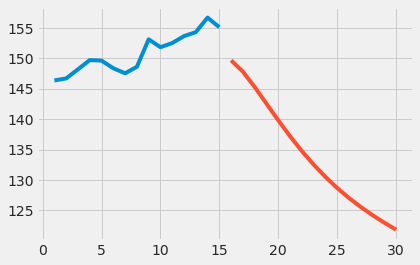

In [48]:
plt.plot(day_new,scaler.inverse_transform(test_data[test_data.shape[0]-15:]))
plt.plot(day_pred,scaler.inverse_transform(lst_output))